In [183]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

import sys
sys.path.append('../Utility')
from plot_utility import plot_tme

# problem statement

figuring out control matrix when its unknown. 


this notebook assumes the control matrix is unknown and time invariant.

In [184]:
# constants

# System Parameters
m = 0.5 # mass
l = 0.2 # distance from rotor to COM
I = 2/5*m*l**2 # Moment of inertia (Iyy) -- assuming drone is a sphere (it is not)
g = 9.81 # gravity constant

# Control Parameters
tau_k_theta = 10 # torque control to stabilize theta
tau_k_thetadot = 20 # torque control to provide thetadot damping
tau_k_x = 0.01 # torque control to control x position
tau_k_xdot = 0.2 # torque control to provide xdot damping
F_k_z = 100 # Force control to control z position
F_k_zdot = 100 # Force control to control z position

F0 = m*g

# Noise for measurements:
#v = [0.01, 0.001, 0.2, 0.2]
v = [0.01, 0.001, 0.2, 0.2, 0.00005, 0.000005]

## trajectories and inputs:

In [185]:
def desired_trajectory(t):
    theta_des = 0*np.ones_like(t)
    z_des = 1*np.ones_like(t)
    x_des = np.sin(0.01*t)
    return theta_des, x_des, z_des


# def generate_excitation(t):
#     F = np.random.randint(0, 100, len(t))
#     tau = np.random.randint(0, 100, len(t))
#     dictionary = {tt: (F[i], tau[i]) for i, tt in enumerate(t)}
#     return dictionary


## functions

In [221]:
def control(X, t):
    theta, thetadot, x, xdot, z, zdot = X
    
    # desired trajectory
    theta_des, x_des, z_des = desired_trajectory(t)
    
    # error
    x_err = x_des - x
    z_err = z_des - z
    
    # control
    tau = -(tau_k_x*x_err - tau_k_xdot*xdot)  + (tau_k_theta*(-theta) - tau_k_thetadot*thetadot)
    F = (F_k_z*z_err - F_k_zdot*zdot)
    return F, tau




def dynamics(X, t, Bnot, inputs=None, export_inputs=None):
    theta, thetadot, x, xdot, z, zdot = X
    
    # control
    # F, tau = control(X, t)
    # u = np.array([F, tau]).reshape(2,1)
    
    if inputs is not None:
        i = np.argmin(np.abs(np.array(list(inputs.keys())) - t))
        F, tau = inputs[list(inputs.keys())[i]]
    else:
        F, tau = control(X, t)
        
    if export_inputs is not None:
        export_inputs.update({t: (F, tau)})
    
        
    
    A = np.array([[0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0]])
    uB = np.array([0, tau, 0, -np.sin(theta)*F, 0, np.cos(theta)*F]).reshape(6,1)
    
    constant = np.array([0, 0, 0, 0, 0, -g]).reshape(6,1)
    
    # dynamics
    dx1 = A@X 
    dx2 = Bnot@uB 
    dx3 = constant
    d_x = dx1.flatten() + dx2.flatten() + dx3.flatten()
    # d_x = [d_theta, d_thetadot, d_x, d_xdot, d_z, d_zdot]
    
    return d_x

In [222]:
# ideal case (reference)

Bnot_ref = np.diag([0, 1/I, 0, 1/m, 0, 1/m]).reshape((6,6))
# Bnot_plant = np.diag([0, 1, 0, 1, 0, 1]).reshape((6,6))
Bnot_plant = np.diag(np.random.randint(1,10, 6)).reshape((6,6))
# Bnot_plant = np.random.randint(1,100, 36).reshape((6,6))

t = np.linspace(0, 1000, 1000)
x0 = [(np.random.random()-0.5)*1e-3 for i in range(6)]


inputs = {}

theta_des, x_des, z_des = desired_trajectory(t)
goal_trajectory = np.array([theta_des, np.zeros_like(theta_des)*np.nan, x_des, np.zeros_like(x_des)*np.nan, z_des, np.zeros_like(z_des)*np.nan]).T

result_ref = odeint(dynamics, x0.copy(), t, args=(Bnot_ref, None, inputs))
x_ref = result_ref.T

result_plant = odeint(dynamics, x0.copy(), t, args=(Bnot_plant, inputs, None))
x_plant = result_plant.T

Bnot_ref, Bnot_plant

/tmp/ipykernel_17108/1663957712.py:20: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  result_plant = odeint(dynamics, x0.copy(), t, args=(Bnot_plant, inputs, None))


(array([[  0.,   0.,   0.,   0.,   0.,   0.],
        [  0., 125.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   2.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   2.]]),
 array([[4, 0, 0, 0, 0, 0],
        [0, 7, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 5, 0, 0],
        [0, 0, 0, 0, 5, 0],
        [0, 0, 0, 0, 0, 4]]))

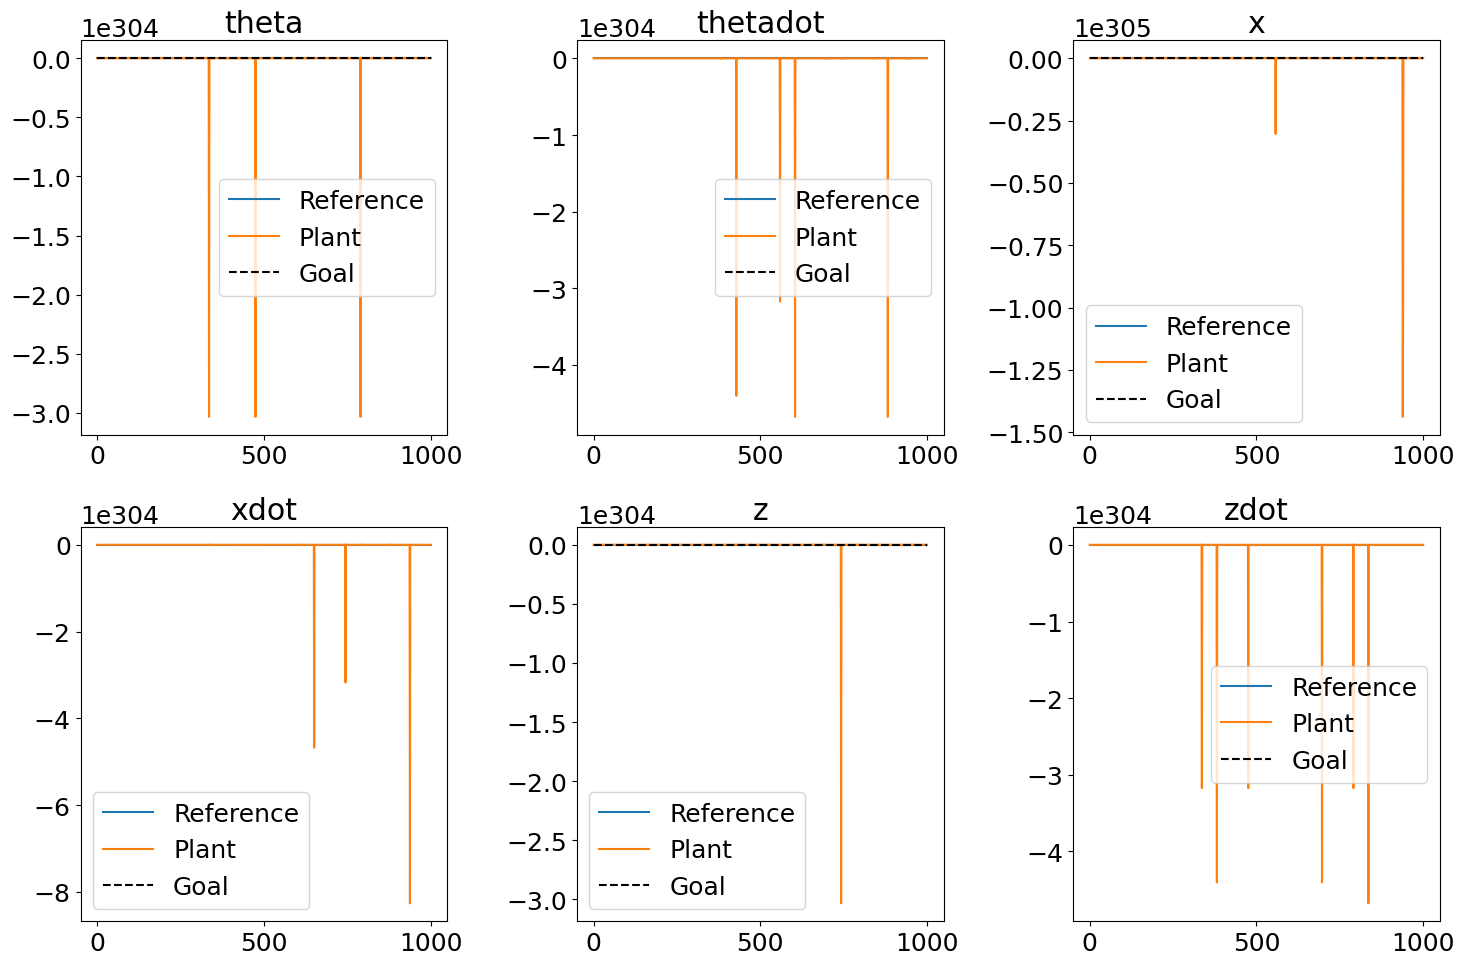

In [223]:
# plot
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()
axs = (ax for ax in axs)

titles = ['theta', 'thetadot', 'x', 'xdot', 'z', 'zdot']

for i in range(6):
    ax = next(axs)
    ax.plot(t, x_ref[i], label='Reference')
    ax.plot(t, x_plant[i], label='Plant')
    ax.set_title(titles[i])
    ax.plot(t, goal_trajectory[:,i], label='Goal', linestyle='--', color='k')
    ax.legend()

fig.tight_layout()